In [1]:
import os
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import gaussian_kde, norm
from astropy.table import Table, vstack

from matplotlib import transforms
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import warnings
warnings.filterwarnings("ignore")

import time
import emcee
import corner
from multiprocessing import Pool

import mcmc_binarity

# Estimating the unresolved binary fraction in nearby open clusters

This notebook shows how to use MCMC in conjunction with a custom mixture model to estimate the unresolved binary fraction in open clusters (given a clean membership list of main-sequence members).

The main functions used are implemented in mcmc_binarity.py.

### Read cluster-member data from the Gaia EDR3 catalogue of Tarricq+2022

The data are stored in a sub-folder of the repository, one ascii file per cluster.

In [2]:
tarricqdir = "data/Tarricq_selected_members_OCs/"
files = os.listdir(tarricqdir)
print(len(files), "OCs selected")

251 OCs selected


### Run the MCMC analysis for 1 cluster (Figure 3)

In [3]:
clusname = "Alessi_1"

Alessi_1 : 46 stars
Maximum likelihood result: [ -21.64258729  136.36487584 -208.77123381  148.82955993  -38.07563126
   -5.38324712    3.02247179]
Running MCMC...


100%|██████████| 8000/8000 [06:29<00:00, 20.56it/s]


Multiprocessing took 389.2 seconds
Mean acceptance fraction: 0.38


<Figure size 432x288 with 0 Axes>

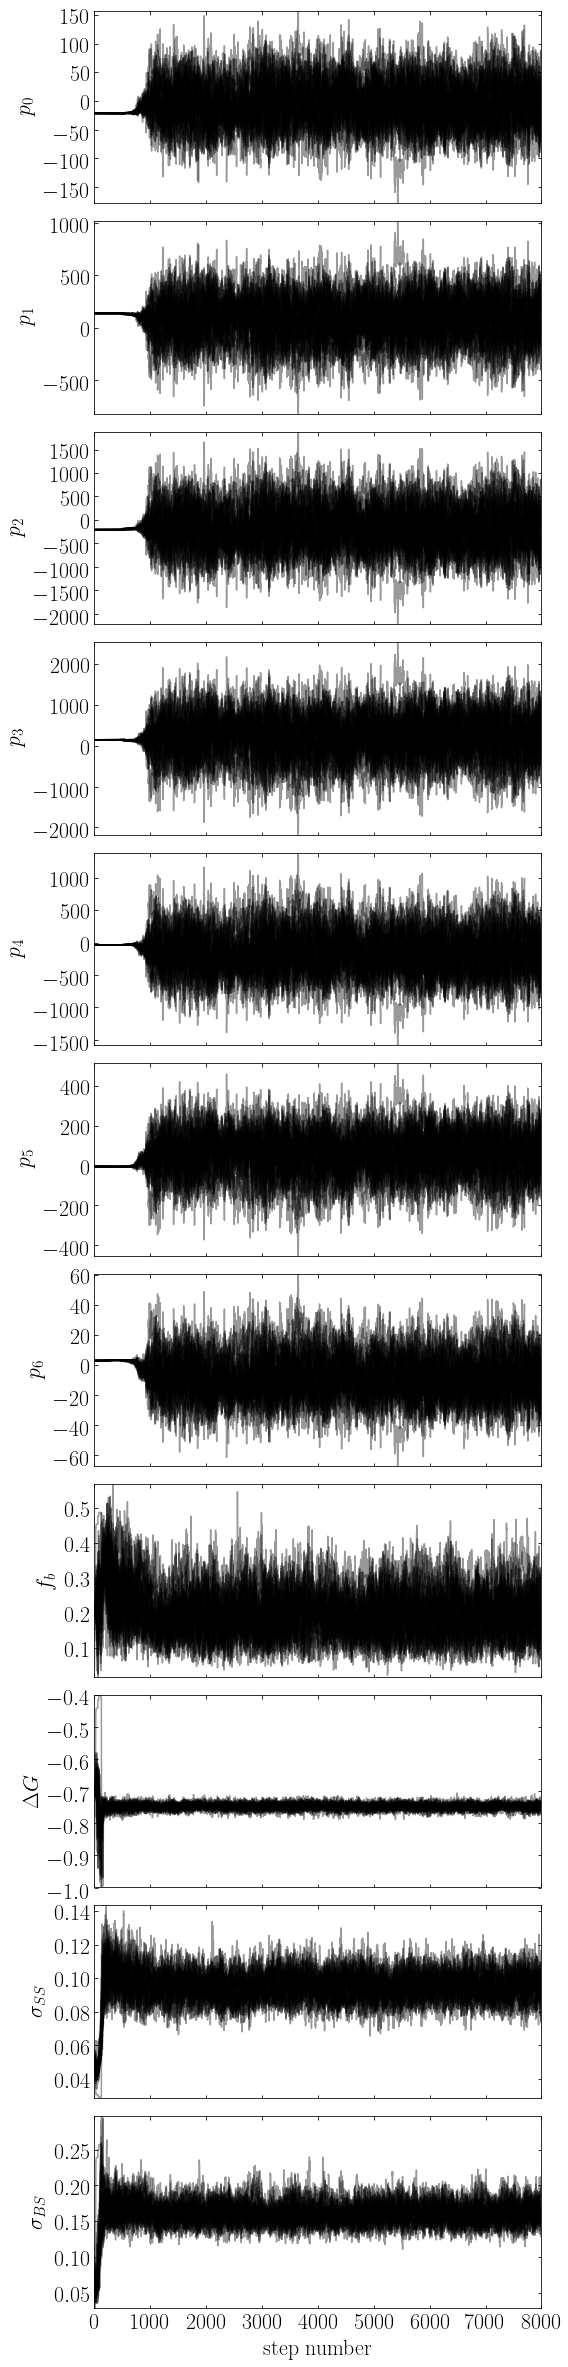

In [4]:
t = Table.read(tarricqdir + clusname + "_sel_MS_members_Tarricq.txt", format="ascii")
x    = t["bp_rp"]
xerr = t["bp_rp_error"]
y    = t["phot_g_mean_mag"]
yerr = t["phot_g_mean_mag_error"]

print(clusname, ":", len(t), "stars")

# Initial guess for a MaxLikelihood fit
theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)

# Set up the MCMC sampler
nwalkers=32
nsteps=8000
burnin=3000
ndim = len(theta0)
pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

print("Running MCMC...")
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

acc_frac = np.mean(sampler.acceptance_fraction)
print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

# Get the marginalised fit parameters
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                np.round(v[2]-v[1],3), 
                                                                np.round(v[1]-v[0],3)), 
                                                     zip(*np.percentile(samples, [16, 50, 84], axis=0)))
# MCMC iteration plot
plt.clf()
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(8, 3*ndim))
poly_labels    = ["$p_0$", "$p_1$", "$p_2$", "$p_3$", "$p_4$", "$p_5$", "$p_6$", "$p_7$", "$p_8$"]
mixture_labels = ["$f_b$","$\Delta G$", "$\sigma_{SS}$", "$\sigma_{BS}$"]
labels         = poly_labels[:(ndim-4)] + mixture_labels
for ii in np.arange(ndim):
    axes[ii].plot(sampler.chain[:, :, ii].T, color="k", alpha=0.4)
    axes[ii].set_ylabel(labels[ii])
axes[ndim-1].set_xlabel("step number")
fig.tight_layout(h_pad=0.0)

Text(0.5, 0.98, 'Alessi 1')

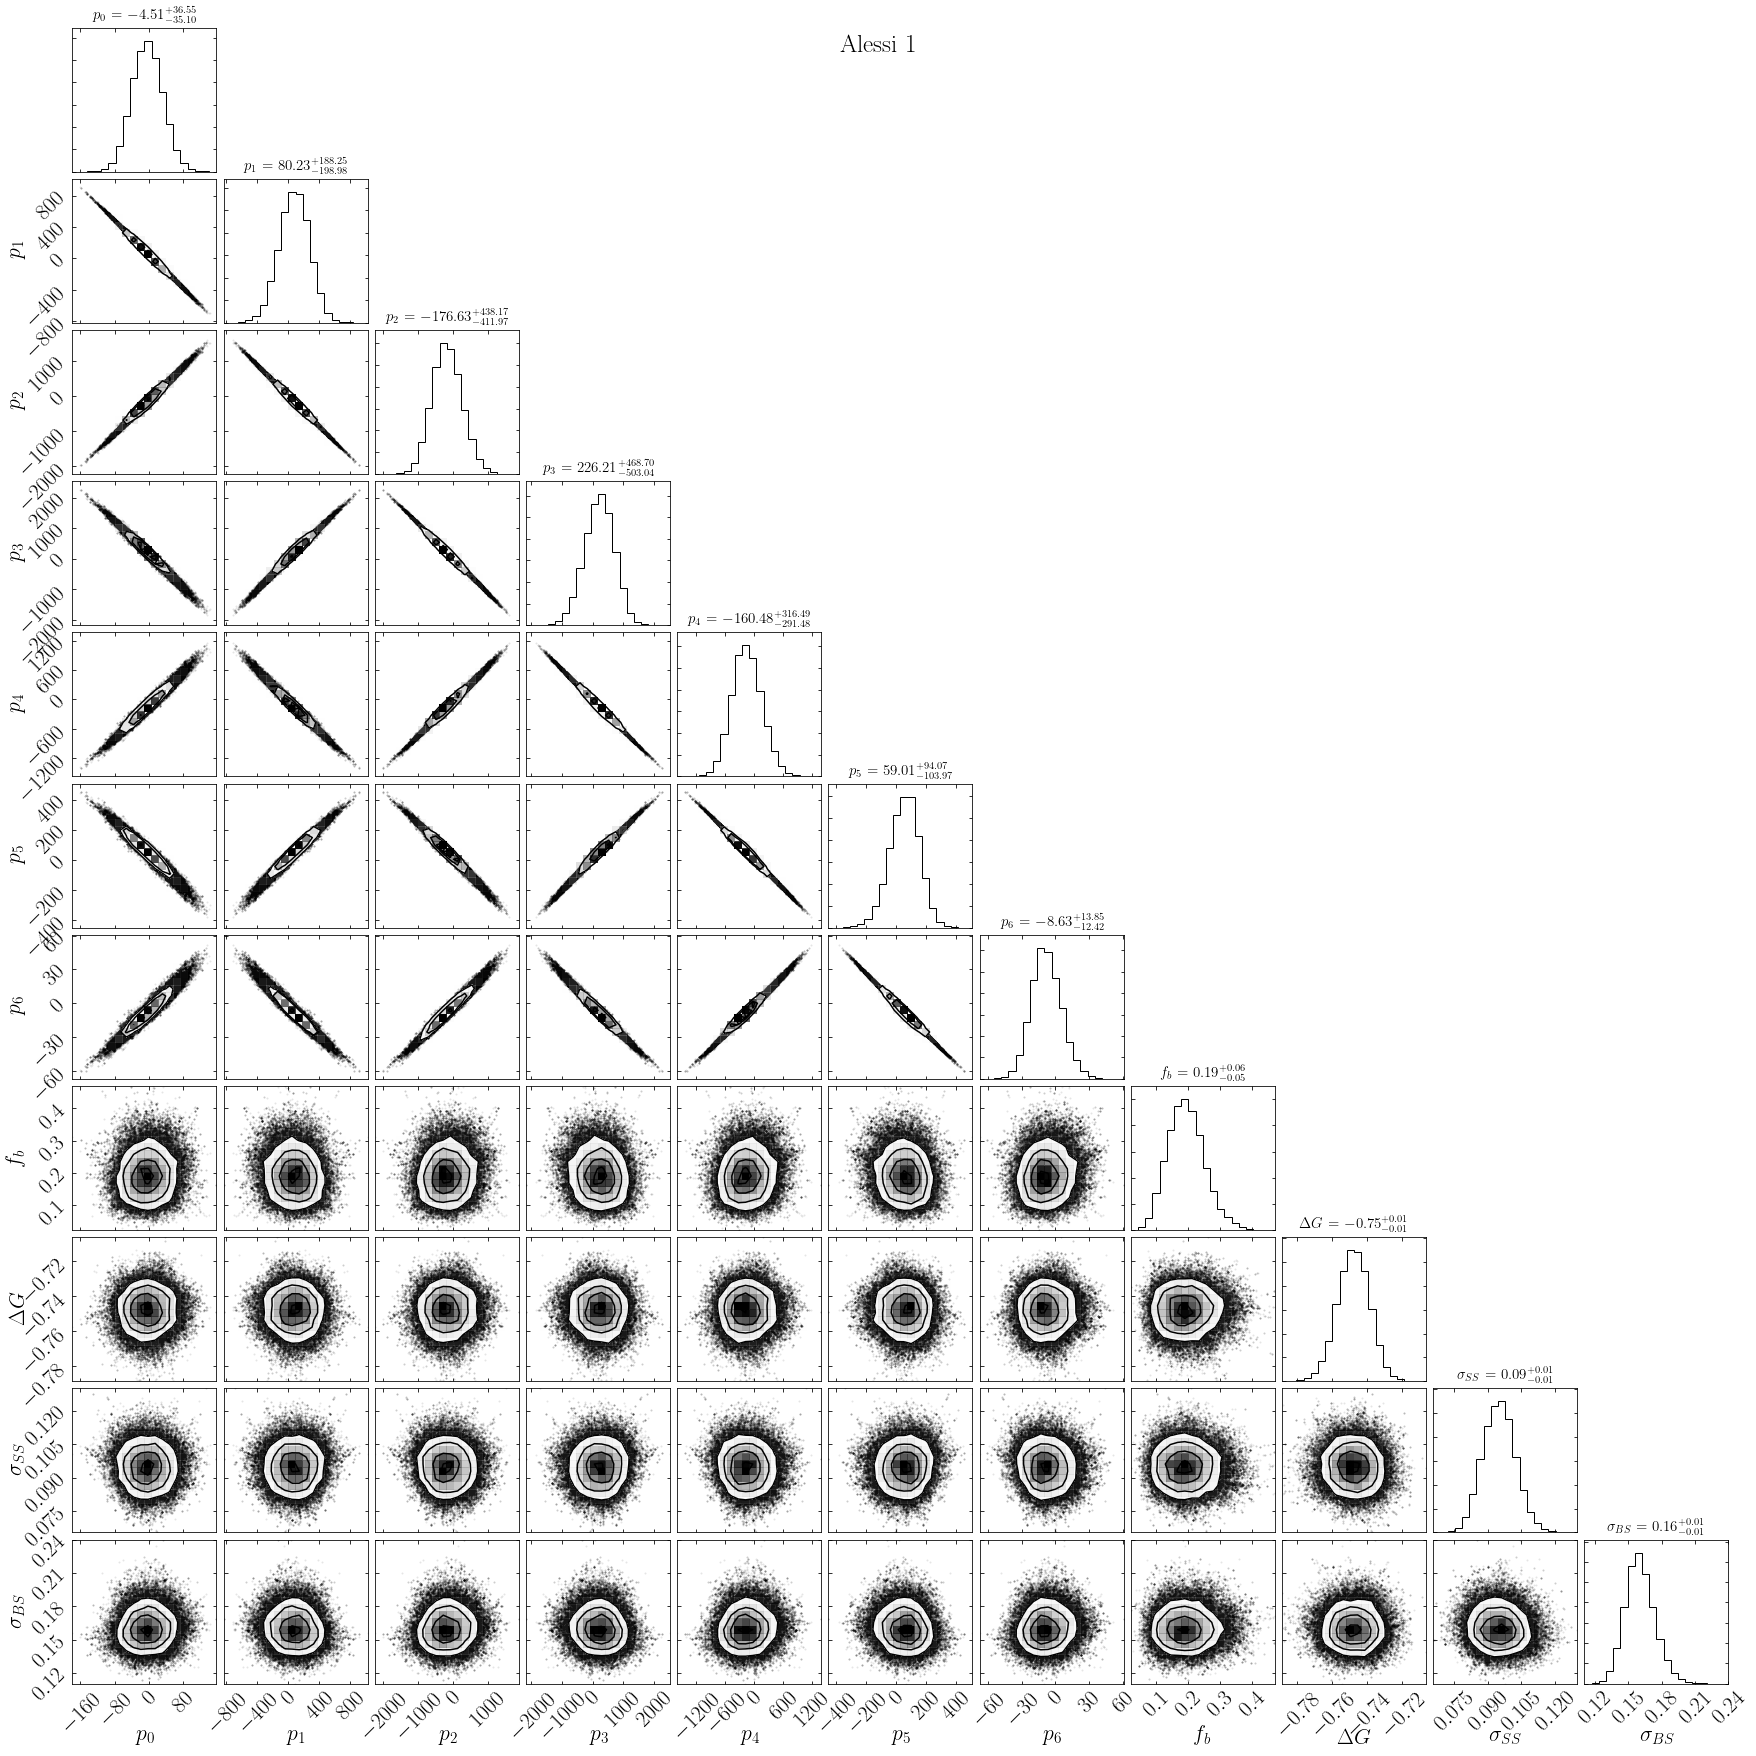

In [5]:
# Corner plot
fig = corner.corner(samples, labels=labels, show_titles=True, title_kwargs={"fontsize": 15})
plt.suptitle(clusname.replace("_", " "), fontsize=25)

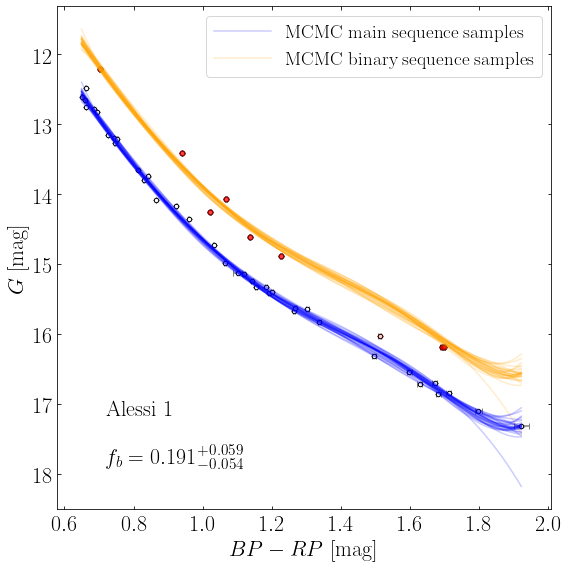

In [6]:
# CMD plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
plt.scatter(x,y, label=None, c="w")
xarr = np.linspace(np.min(x),np.max(x),100)
# Plot the maximum likelihood result.
polynom = np.poly1d(theta0[:-4][::-1])
fb_simple=[]
#plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
# Plot some MCMC samples onto the data.
for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
    bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
    plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
    binaries = (y < ms(x) - 3 * sM)
    fb_simple.append(np.sum(binaries)/len(x))
    plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
# Plot the best-parameter result.
#polynom = np.poly1d([p6_m[0],p5_m[0],p4_m[0],p3_m[0],p2_m[0],p1_m[0],p0_m[0]])
plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
plt.ylabel(r"$G$ [mag]", fontsize=22)
plt.legend(loc="upper right", fontsize=19)
# Annotate name of the cluster and binary fraction
ax = plt.gca()
plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
         verticalalignment='center', transform=ax.transAxes, fontsize=22)
plt.text(0.1, 0.1, r"$f_b={{{0:.3f}}}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("im_mcmc/im_mcmc_tarricq/cmd_fit_mcmc_"+ clusname +".png")

### Histogram of $\Delta G_i$

0.095


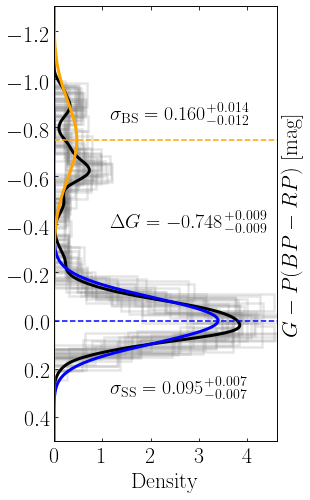

In [9]:
plt.figure(figsize=(4,8))
ax = plt.subplot(111)
# first of all, the base transformation of the data points is needed
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)

edges = [-1.3,.5]

kdearr = np.linspace(edges[0], edges[1],1000)
kderes = np.zeros(1000)

for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
    ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
    # Compute Delta G_i
    DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
    vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                   label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                   color="grey", transform= rot + base)
    kde = gaussian_kde(y - ms(x), bw_method=.1)
    kderes = kderes + kde.evaluate(kdearr)
plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)

# Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)

ax.axhline(0.,      c="b", ls="dashed")
ax.axhline(DG_m[0], c="orange", ls="dashed")

# Beautify the plot
ax2 = ax.twinx() 
ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
ax.set_xlabel(r"Density") 
ax2.set_xlim(0, 1.2*np.max(kderes/30)) 
ax2.set_yticks([]) 
ax.set_ylim(edges[1], edges[0]) 
print(sM_m[0])

plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.3f}}}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(sM_m[0],sM_m[1],sM_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.text(0.25, 0.5, r"$\Delta G={{{0:.3f}}}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(DG_m[0],DG_m[1],DG_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.3f}}}^{{+{1:.3f}}}_{{-{2:.3f}}}$".format(sB_m[0],sB_m[1],sB_m[2]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")

## Analysis pipeline for the Tarricq+2022 OCs

In [12]:
# Where to store all the plots:
plotdir="./im_mcmc/im_mcmc_tarricq/"
if not os.path.exists(plotdir):
    os.mkdir(plotdir)

In [14]:
for ii in [0,1,2]:
    t = Table.read(tarricqdir + files[ii], format="ascii")
    x    = t["bp_rp"]
    xerr = t["bp_rp_error"]
    y    = t["phot_g_mean_mag"]
    yerr = t["phot_g_mean_mag_error"]
    clusname = files[ii][:-27]

    print(clusname, ":", len(t), "stars")

    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Set up the MCMC sampler
    nwalkers=32
    nsteps=15000
    burnin=2000
    ndim = len(theta0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    print("Running MCMC...")
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
        start = time.time()
        sampler.run_mcmc(pos, nsteps, progress=True)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))

    acc_frac = np.mean(sampler.acceptance_fraction)
    print("Mean acceptance fraction: {0:.2f}".format(acc_frac))
    
    if acc_frac > 0.05:
        # Get the marginalised fit parameters
        samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                        np.round(v[2]-v[1],3), 
                                                                        np.round(v[1]-v[0],3)), 
                                                             zip(*np.percentile(samples, [16, 50, 84], axis=0)))

        # CMD plot
        plt.figure(figsize=(8,8))
        plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
        plt.scatter(x,y, label=None, c="w", edgecolors="black")
        xarr = np.linspace(np.min(x),np.max(x),100)
        # Plot the maximum likelihood result.
        #polynom = np.poly1d(theta0[:-4][::-1])
        #plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
        # Plot some MCMC samples onto the data.
        fb_simple=[]
        for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=25)]:
            ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
            plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
            bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
            plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
            binaries = (y < ms(x) - 3 * sM)
            fb_simple.append(np.sum(binaries)/len(x))
            plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
        fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])    
        # Plot the best-parameter result.
        plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
        plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
        plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
        plt.ylabel(r"$G$ [mag]", fontsize=22)
        plt.legend(loc="upper right", fontsize=19)
        # Annotate name of the cluster and binary fraction
        ax = plt.gca()
        plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
                 verticalalignment='center', transform=ax.transAxes, fontsize=22)
        plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
        #plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
        #         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
        ax.invert_yaxis()
        plt.tight_layout()
        
        plt.savefig(plotdir+"cmd_fit_mcmc_"+clusname+".png")
        plt.close()
        
        #CMD residuals plot
        plt.figure(figsize=(4,8))
        ax = plt.subplot(111)
        # first of all, the base transformation of the data points is needed
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(-90)
        edges = [-1.3,.5]
        kdearr = np.linspace(edges[0], edges[1],1000)
        kderes = np.zeros(1000)
        for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
            ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
            # Compute Delta G_i
            DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
            vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                       label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                       color="grey", transform= rot + base)
            kde = gaussian_kde(y - ms(x), bw_method=.1)
            kderes = kderes + kde.evaluate(kdearr)
        plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)
        # Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
        plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
        plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)
        ax.axhline(0.,      c="b", ls="dashed")
        ax.axhline(DG_m[0], c="orange", ls="dashed")
        # Beautify the plot
        ax2 = ax.twinx() 
        ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
        ax.set_xlabel(r"Density") 
        ax2.set_xlim(0, np.max([1.2*np.max(kderes/30), 5.])) 
        ax2.set_yticks([]) 
        ax.set_ylim(edges[1], edges[0])
        # Overshade in red those OCs that will be discarded
        if abs(DG_m[0] + 0.75) > 0.1 or sB_m[0] > 0.25 or sM_m[0] > 0.2:
            ax.set_facecolor("mistyrose")
        plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sM_m[0], sM_m[1], sM_m[2]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(DG_m[0], DG_m[1], DG_m[2]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sB_m[0], sB_m[1], sB_m[2]), 
             horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
        plt.savefig("./im_mcmc/im_mcmc_tarricq/cmd_fit_residuals_" + clusname + ".png")
        plt.close()
        
        #  save / return the results as a one-row astropy table
        result = Table(names=('clus', 'nb_MS_members', 'MS_width', 'nsteps', 'burnin', 'acc_frac', 
                         'fb_ref_50', 'fb_ref_sigu', 'fb_ref_sigl', 'fb_50', 'fb_sigu', 'fb_sigl', 
                         'DG_50', 'DG_sigu', 'DG_sigl', 
                         'sM_50', 'sM_sigu', 'sM_sigl', 'sB_50', 'sB_sigu', 'sB_sigl'), 
                  dtype=('S20', 'i4', 'f4', 'i4', 'i4', 'f4', 'f4', 'f4', 'f4', 
                         'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))
        result.add_row((clusname, len(x), np.max(x)-np.min(x), nsteps, burnin, np.round(acc_frac,2), 
                   fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1],
                   fb_m[0], fb_m[1], fb_m[2], DG_m[0], DG_m[1], DG_m[2], 
                   sM_m[0], sM_m[1], sM_m[2], sB_m[0], sB_m[1], sB_m[2]))        
        # Save the results
        if ii == 0:
            restable = result
        else:
            if result == None:
                pass
            else:
                restable = vstack([restable, result])
        restable.write("data/mcmc_results_tarricq_summary_test.fits", overwrite=True)
        

NGC_2539 : 418 stars
Maximum likelihood result: [  12.93948264    1.23912693  -28.06473138  101.92071616 -129.49545761
   72.74222775  -15.38656731]
Running MCMC...


100%|██████████| 15000/15000 [12:38<00:00, 19.78it/s]


Multiprocessing took 758.6 seconds
Mean acceptance fraction: 0.40
Melotte_22 : 1158 stars
Maximum likelihood result: [ 6.96218491  3.12858113 -0.28563707  3.05922272 -2.87269688  0.94208868
 -0.1043249 ]
Running MCMC...


100%|██████████| 15000/15000 [16:32<00:00, 15.12it/s]


Multiprocessing took 992.4 seconds
Mean acceptance fraction: 0.40
UPK_90 : 47 stars
Maximum likelihood result: [-2.42943713e-01  7.96579234e+01 -2.33114028e+02  3.78413264e+02
 -3.35108059e+02  1.51463497e+02 -2.71663865e+01]
Running MCMC...


100%|██████████| 15000/15000 [17:14<00:00, 14.50it/s]


Multiprocessing took 1034.2 seconds
Mean acceptance fraction: 0.36


The full sample can be run by calling

### Do the same for the Cantat+2020 sample

In [15]:
cantatdir = "data/Cantat_selected_members_OCs_younger50Myr/"
files = os.listdir(cantatdir)
print(len(files), "OCs selected")

128 OCs selected


In [16]:
plotdir="./im_mcmc/im_mcmc_cantat/"
if not os.path.exists(plotdir):
    os.mkdir(plotdir)

In [17]:
for ii in [0,1,2]:
    t = Table.read(cantatdir + files[ii], format="ascii")
    x    = t["BP-RP"]
    xerr = np.sqrt((2.5 * np.log10(1 + 1./t["phot_bp_mean_flux_over_error"]))**2 +
                   (2.5 * np.log10(1 + 1./t["phot_rp_mean_flux_over_error"]))**2)
    y    = t["Gmag"]
    yerr = 2.5 * np.log10(1 + 1./t["phot_g_mean_flux_over_error"])
    clusname = files[ii][:-26]

    print(clusname, ":", len(t), "stars")

    # Initial guess for ML fit
    theta0 = [0.6, 5.67, -0.66, -0.32, 0.09, 0., 0., 0.2, -0.7, 0.05, 0.05]
    Nfit   = len(theta0)# First find the maximum likelihood values for the simple fit model.
    theta0 = mcmc_binarity.maxlike(theta0, x, y, yerr)
    # Set up the MCMC sampler
    nwalkers=32
    nsteps=5000
    burnin=1000
    ndim = len(theta0)
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    try:
        print("Running MCMC...")
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, mcmc_binarity.lnprob2, args=(x, y, xerr, yerr), pool=pool)
            start = time.time()
            sampler.run_mcmc(pos, nsteps, progress=True)
            end = time.time()
            multi_time = end - start
            print("Multiprocessing took {0:.1f} seconds".format(multi_time))

        acc_frac = np.mean(sampler.acceptance_fraction)
        print("Mean acceptance fraction: {0:.2f}".format(acc_frac))

        if acc_frac > 0.05:
            # Get the marginalised fit parameters
            samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
            p0_m,p1_m,p2_m,p3_m,p4_m,p5_m,p6_m,fb_m,DG_m,sM_m,sB_m = map(lambda v: (np.round(v[1],3), 
                                                                            np.round(v[2]-v[1],3), 
                                                                            np.round(v[1]-v[0],3)), 
                                                                 zip(*np.percentile(samples, [16, 50, 84], axis=0)))

            # CMD plot
            plt.figure(figsize=(8,8))
            plt.errorbar(x,y,xerr=xerr, yerr=yerr, ls='none', label=None, c="grey", zorder=0)
            plt.scatter(x,y, label=None, c="w", edgecolors="black")
            xarr = np.linspace(np.min(x),np.max(x),100)
            # Plot the maximum likelihood result.
            #polynom = np.poly1d(theta0[:-4][::-1])
            #plt.plot(xarr, polynom(xarr), lw=2, c="grey", label="Max. likelihood fit")
            # Plot some MCMC samples onto the data.
            fb_simple=[]
            for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=25)]:
                ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
                plt.plot(xarr, ms(xarr), color="b", alpha=0.2)
                bs = np.poly1d([p6,p5,p4,p3,p2,p1,p0+DG])
                plt.plot(xarr, bs(xarr), color="orange", alpha=0.2)
                binaries = (y < ms(x) - 3 * sM)
                fb_simple.append(np.sum(binaries)/len(x))
                plt.scatter(x[binaries],y[binaries], label=None, c="r", s=30, lw=0.3, alpha=.04)
            fb_simple = np.percentile(np.array(fb_simple), [16, 50, 84])    
            # Plot the best-parameter result.
            plt.plot(xarr, ms(xarr), c='blue', label="MCMC main sequence samples", alpha=0.2)
            plt.plot(xarr, bs(xarr), c='orange', label="MCMC binary sequence samples", alpha=0.2)
            plt.xlabel(r"$BP-RP$ [mag]", fontsize=22)
            plt.ylabel(r"$G$ [mag]", fontsize=22)
            plt.legend(loc="upper right", fontsize=19)
            # Annotate name of the cluster and binary fraction
            ax = plt.gca()
            plt.text(0.1, 0.2, clusname.replace("_", " "), horizontalalignment='left',
                     verticalalignment='center', transform=ax.transAxes, fontsize=22)
            plt.text(0.1, 0.1, r"$f_b={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_m[0],fb_m[1],fb_m[2]), 
                     horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
            #plt.text(0.1, 0.1, r"$f_b^{{\rm referee}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1]), 
            #         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=22)
            ax.invert_yaxis()
            plt.tight_layout()

            plt.savefig(plotdir+"cmd_fit_mcmc_"+clusname+".png")
            plt.close()

                    
            #CMD residuals plot
            plt.figure(figsize=(4,8))
            ax = plt.subplot(111)
            # first of all, the base transformation of the data points is needed
            base = plt.gca().transData
            rot = transforms.Affine2D().rotate_deg(-90)
            edges = [-1.3,.5]
            kdearr = np.linspace(edges[0], edges[1],1000)
            kderes = np.zeros(1000)
            for p0,p1,p2,p3,p4,p5,p6,fb,DG,sM,sB in samples[np.random.randint(len(samples), size=30)]:
                ms = np.poly1d([p6,p5,p4,p3,p2,p1,p0])
                # Compute Delta G_i
                DGi  = (y - ms(x))[(y - ms(x)<edges[1]) & (y - ms(x)>edges[0])]
                vals, bins, patches = plt.hist(-DGi, density=True, histtype="step", bins="fd", lw=2.5,
                                           label="Gaia DR2 open clusters ($d < 1.5$ kpc)", alpha=.2, 
                                           color="grey", transform= rot + base)
                kde = gaussian_kde(y - ms(x), bw_method=.1)
                kderes = kderes + kde.evaluate(kdearr)
            plt.plot(-kdearr, kderes/30, c="k", lw=3, alpha=1, transform= rot + base)
            # Overplot the 2 Gaussians #fb_m,DG_m,sM_m,sB_m
            plt.plot(-kdearr, (1-fb_m[0]) * norm.pdf(kdearr, loc=0., scale=sM_m[0]), c="b", lw=3, alpha=1, transform= rot + base)
            plt.plot(-kdearr,   fb_m[0]   * norm.pdf(kdearr, loc=DG_m[0], scale=sB_m[0]), c="orange", lw=3, alpha=1, transform= rot + base)
            ax.axhline(0.,      c="b", ls="dashed")
            ax.axhline(DG_m[0], c="orange", ls="dashed")
            # Beautify the plot
            ax2 = ax.twinx() 
            ax2.set_ylabel(r"$G-P(BP-RP)$  [mag]") 
            ax.set_xlabel(r"Density") 
            ax2.set_xlim(0, np.max([1.2*np.max(kderes/30), 5.])) 
            ax2.set_yticks([]) 
            ax.set_ylim(edges[1], edges[0])
            # Overshade in red those OCs that will be discarded
            if abs(DG_m[0] + 0.75) > 0.1 or sB_m[0] > 0.25 or sM_m[0] > 0.2:
                ax.set_facecolor("mistyrose")
            plt.text(0.25, 0.12, r"$\sigma_{{\rm SS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sM_m[0], sM_m[1], sM_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
            plt.text(0.25, 0.5, r"$\Delta G={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(DG_m[0], DG_m[1], DG_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
            plt.text(0.25, 0.75, r"$\sigma_{{\rm BS}}={{{0:.2f}}}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(sB_m[0], sB_m[1], sB_m[2]), 
                 horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=20)
            plt.savefig(plotdir+"cmd_fit_residuals_" + clusname + ".png")
            plt.close()


            #  save / return the results as a one-row astropy table
            result = Table(names=('clus', 'nb_MS_members', 'MS_width', 'nsteps', 'burnin', 'acc_frac', 
                             'fb_ref_50', 'fb_ref_sigu', 'fb_ref_sigl', 'fb_50', 'fb_sigu', 'fb_sigl', 
                             'DG_50', 'DG_sigu', 'DG_sigl', 
                             'sM_50', 'sM_sigu', 'sM_sigl', 'sB_50', 'sB_sigu', 'sB_sigl'), 
                      dtype=('S20', 'i4', 'f4', 'i4', 'i4', 'f4', 'f4', 'f4', 'f4', 
                             'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4'))
            result.add_row((clusname, len(x), np.max(x)-np.min(x), nsteps, burnin, np.round(acc_frac,2), 
                       fb_simple[1],fb_simple[1]-fb_simple[0],fb_simple[2]-fb_simple[1],
                       fb_m[0], fb_m[1], fb_m[2], DG_m[0], DG_m[1], DG_m[2], 
                       sM_m[0], sM_m[1], sM_m[2], sB_m[0], sB_m[1], sB_m[2]))        
            # Save the results
            if ii == 0:
                restable = result
            else:
                if result == None:
                    pass
                else:
                    restable = vstack([restable, result])
            restable.write("data/mcmc_results_cantat_summary_refereetest.fits", overwrite=True)
    except:
        pass
        

IC_4665 : 156 stars
Maximum likelihood result: [  7.41292177  10.60283587 -15.33768406  16.04315963  -8.40592276
   2.10383616  -0.20199593]
Running MCMC...


100%|██████████| 5000/5000 [07:00<00:00, 11.88it/s]


Multiprocessing took 421.1 seconds
Mean acceptance fraction: 0.39
UBC_7 : 68 stars
Maximum likelihood result: [ 9.59227064 -2.61101342 11.89631997 -8.24583773  1.73742463  0.19391842
 -0.07912377]
Running MCMC...


100%|██████████| 5000/5000 [07:20<00:00, 11.34it/s]


Multiprocessing took 440.8 seconds
Mean acceptance fraction: 0.37
Trumpler_3 : 202 stars
Maximum likelihood result: [   2.88671737   47.98583529 -104.34386032  116.579827    -65.9588753
   18.21560108   -1.95153297]
Running MCMC...


100%|██████████| 5000/5000 [07:30<00:00, 11.11it/s]


Multiprocessing took 450.1 seconds
Mean acceptance fraction: 0.40


Similarly, the full analysis of the Cantat+2020 young OC sample can be run by calling